In [33]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_path = '/content/drive/MyDrive/Disease Detection.zip'
extract_path = '/content/drive/MyDrive/'

In [ ]:
import zipfile
import os

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction completed.")
else:
    print("Files already extracted.")

# Verify extraction with limited output
print("Directory structure (limited):\n")
for root, dirs, files in os.walk(extract_path):
    level = root.replace(extract_path, '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 4 * (level + 1)
    # Limit number of directories and files printed
    for f in files[:3]:  # Show up to 3 files only
        print(f"{subindent}{f}")
    if len(files) > 3:
        print(f"{subindent}...and {len(files) - 3} more files")
    if level >= 1:  # Limit to top-level and one subdirectory
        break


Files already extracted.
Directory structure (limited):

/
    Disease Detection.zip
    skin_lesion_cnn_model.h5
    X_train.npy
    ...and 3 more files
Colab Notebooks/
    Mental Health Detection.ipynb
    Untitled0.ipynb
    Election_Data_Analysis_final.ipynb
    ...and 6 more files
dataverse_files/
    HAM10000_images_part_1.zip
    HAM10000_images_part_2.zip
    ISIC2018_Task3_Test_Images.zip
    ...and 4 more files
Disease Detection/
    .DS_Store
    melanoma_cancer_dataset-2/
        .DS_Store


In [ ]:
chest_xray_dir = '/content/drive/MyDrive/Disease Detection/chest_xray'
melanoma_dir = '/content/drive/MyDrive/Disease Detection/melanoma_cancer_dataset-2'

In [ ]:
# Set parameters
img_size = (128, 128)
batch_size = 32

In [ ]:
# Data Augmentation and Preprocessing
data_gen = ImageDataGenerator(
    rescale=1./255,               # Normalization
    rotation_range=20,             # Random rotations
    width_shift_range=0.2,         # Random horizontal shifts
    height_shift_range=0.2,        # Random vertical shifts
    shear_range=0.2,               # Shear transformations
    zoom_range=0.2,                # Zoom transformations
    horizontal_flip=True,          # Random horizontal flipping
    validation_split=0.2           # Using 20% of data for validation
)

In [ ]:
# Loading data for Chest X-ray (Pneumonia Detection)
train_chest_xray = data_gen.flow_from_directory(
    chest_xray_dir + '/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_chest_xray = data_gen.flow_from_directory(
    chest_xray_dir + '/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


In [ ]:
# Load data for Melanoma Skin Cancer Detection
train_melanoma = data_gen.flow_from_directory(
    melanoma_dir + '/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_melanoma = data_gen.flow_from_directory(
    melanoma_dir + '/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

Found 7684 images belonging to 2 classes.
Found 1921 images belonging to 2 classes.


In [ ]:
# Visualize sample images with labels
def plot_images(data_gen, title):
    images, labels = next(data_gen)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title("Label: " + str(labels[i]))
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

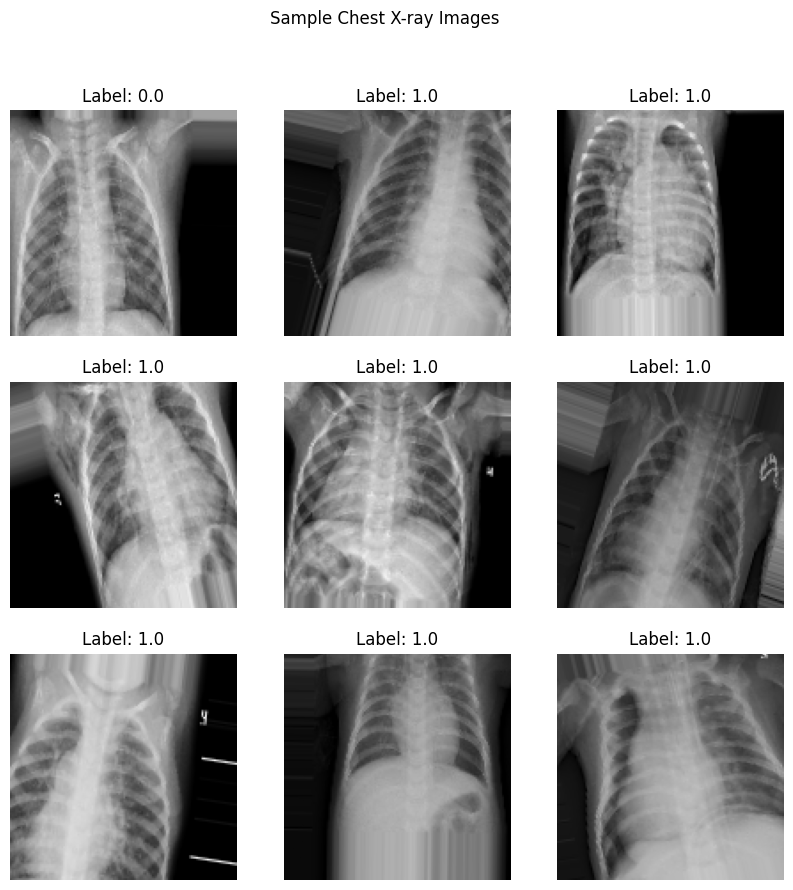

In [ ]:
plot_images(train_chest_xray, "Sample Chest X-ray Images")

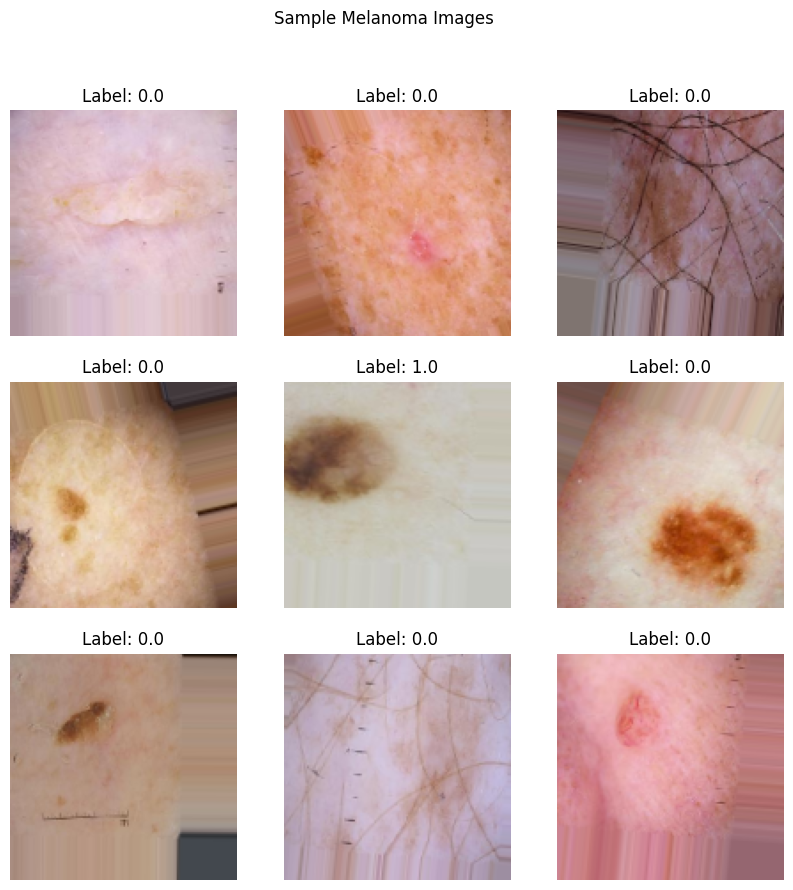

In [ ]:
plot_images(train_melanoma, "Sample Melanoma Images")

#CNN

In [45]:
# Define a CNN Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input

# Define a CNN Model
def create_cnn_model():
    model = Sequential([
        Input(shape=(img_size[0], img_size[1], 3)),
        Conv2D(32, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),  # Added L2 regularization
        Dropout(0.4),  # Increased dropout
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    model.compile(optimizer=Adam(learning_rate=0.0005),  # Lowered learning rate
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [46]:
model = create_cnn_model()

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

In [47]:
history = model.fit(
    train_chest_xray,
    validation_data=val_chest_xray,
    epochs=20,
    callbacks=[early_stopping, lr_scheduler],
    batch_size=16
)

Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 80s 549ms/step - accuracy: 0.8127 - loss: 3.1191 - val_accuracy: 0.7430 - val_loss: 8.6868 - learning_rate: 5.0000e-04
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 71s 517ms/step - accuracy: 0.8511 - loss: 1.4736 - val_accuracy: 0.7430 - val_loss: 8.6296 - learning_rate: 5.0000e-04
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 71s 517ms/step - accuracy: 0.8848 - loss: 0.9179 - val_accuracy: 0.7430 - val_loss: 11.1673 - learning_rate: 5.0000e-04
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 71s 519ms/step - accuracy: 0.8893 - loss: 0.6940 - val_accuracy: 0.7440 - val_loss: 4.9145 - learning_rate: 5.0000e-04
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 71s 515ms/step - accuracy: 0.8929 - loss: 0.6210 - val_accuracy: 0.7929 - val_loss: 0.9137 - learning_rate: 5.0000e-04
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 71s 521ms/step - accuracy: 0.8822 - loss: 0.6485 - val_accuracy: 0.5695 - val_loss: 1.0731 - learning_rate: 5.0000e-04
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 71s 5

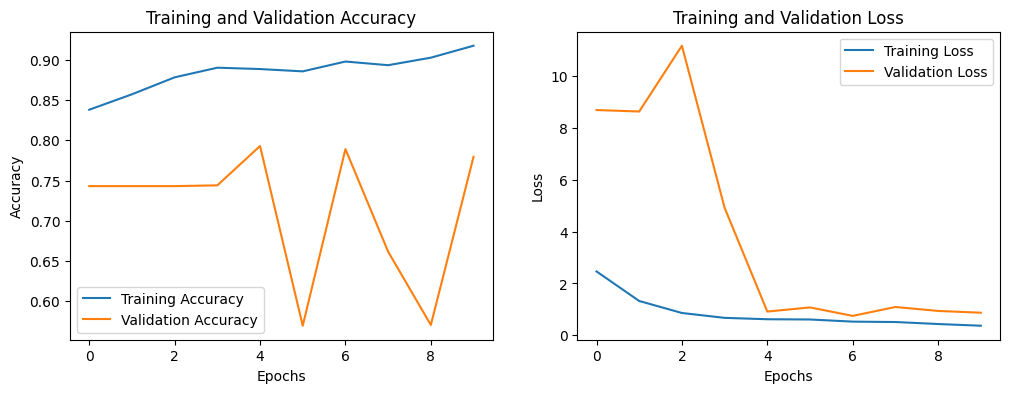

In [48]:
# Plotting training results
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

plot_training_history(history)

In [49]:
# Evaluate the model on test data (you can add similar evaluation for melanoma test data as well)
test_chest_xray = data_gen.flow_from_directory(
    chest_xray_dir + '/test',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_loss, test_accuracy = model.evaluate(test_chest_xray)
print(f'Test Accuracy: {test_accuracy:.2f}')
print(f'Test Loss: {test_loss:.2f}')

Found 624 images belonging to 2 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 411ms/step - accuracy: 0.7704 - loss: 0.7644
Test Accuracy: 0.76
Test Loss: 0.77


#VGG

In [ ]:
vgg_model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(256, (3, 3), activation='relu'),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

vgg_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [ ]:
print("Training VGG model...")
vgg_history = vgg_model.fit(
    train_chest_xray,
    validation_data=val_chest_xray,
    epochs=10
)

Training VGG model...
Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 86s 564ms/step - accuracy: 0.7624 - loss: 2.8904 - val_accuracy: 0.7430 - val_loss: 3.7350
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 71s 520ms/step - accuracy: 0.8340 - loss: 0.6623 - val_accuracy: 0.7430 - val_loss: 8.0200
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 71s 515ms/step - accuracy: 0.8663 - loss: 0.3987 - val_accuracy: 0.7430 - val_loss: 8.2178
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 71s 516ms/step - accuracy: 0.8914 - loss: 0.3398 - val_accuracy: 0.7478 - val_loss: 4.7505
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 71s 521ms/step - accuracy: 0.8752 - loss: 0.3457 - val_accuracy: 0.7430 - val_loss: 5.3151
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 72s 527ms/step - accuracy: 0.8909 - loss: 0.2632 - val_accuracy: 0.7421 - val_loss: 1.6141
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 72s 527ms/step - accuracy: 0.8976 - loss: 0.2614 - val_accuracy: 0.7430 - val_loss: 3.5900
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 71s 522ms/step - accu

In [ ]:
vgg_test_loss, vgg_test_accuracy = vgg_model.evaluate(test_chest_xray)
print(f"VGG Model Test Accuracy: {vgg_test_accuracy:.2f}")
print(f"VGG Model Test Loss: {vgg_test_loss:.2f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 435ms/step - accuracy: 0.6071 - loss: 1.1532
VGG Model Test Accuracy: 0.63
VGG Model Test Loss: 1.12


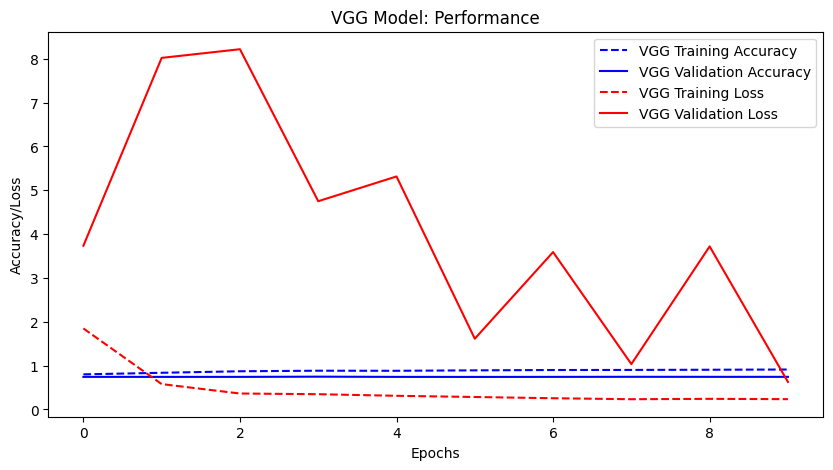

In [ ]:
# Plotting for VGG Model
plt.figure(figsize=(10, 5))
plt.plot(vgg_history.history['accuracy'], label='VGG Training Accuracy', color='blue', linestyle='--')
plt.plot(vgg_history.history['val_accuracy'], label='VGG Validation Accuracy', color='blue')
plt.plot(vgg_history.history['loss'], label='VGG Training Loss', color='red', linestyle='--')
plt.plot(vgg_history.history['val_loss'], label='VGG Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.title('VGG Model: Performance')
plt.legend()
plt.show()


#ResNet

In [34]:
# ResNet model
resnet_model = Sequential([
    Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    BatchNormalization(),
    MaxPooling2D((3, 3), strides=(2, 2), padding='same'),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [36]:
resnet_model.compile(optimizer=Adam(learning_rate=0.001),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])


print("Training ResNet model...")
resnet_history = resnet_model.fit(
    train_chest_xray,
    validation_data=val_chest_xray,
    epochs=10
)

Training ResNet-inspired model...
Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 80s 549ms/step - accuracy: 0.7456 - loss: 1.5548 - val_accuracy: 0.7430 - val_loss: 4.9054
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 71s 522ms/step - accuracy: 0.8613 - loss: 0.3008 - val_accuracy: 0.7430 - val_loss: 5.8784
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 72s 524ms/step - accuracy: 0.8712 - loss: 0.2963 - val_accuracy: 0.2627 - val_loss: 4.4131
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 73s 534ms/step - accuracy: 0.8924 - loss: 0.2648 - val_accuracy: 0.7430 - val_loss: 6.6705
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 73s 532ms/step - accuracy: 0.8875 - loss: 0.2829 - val_accuracy: 0.7430 - val_loss: 5.4104
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 71s 517ms/step - accuracy: 0.8970 - loss: 0.2584 - val_accuracy: 0.7421 - val_loss: 2.5999
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 73s 531ms/step - accuracy: 0.9059 - loss: 0.2392 - val_accuracy: 0.7430 - val_loss: 6.7620
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 71s 520ms

In [37]:
resnet_test_loss, resnet_test_accuracy = resnet_model.evaluate(test_chest_xray)
print(f"ResNet Model Test Accuracy: {resnet_test_accuracy:.2f}")
print(f"ResNet Model Test Loss: {resnet_test_loss:.2f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 407ms/step - accuracy: 0.6257 - loss: 18.0570
ResNet-inspired Model Test Accuracy: 0.62
ResNet-inspired Model Test Loss: 17.86


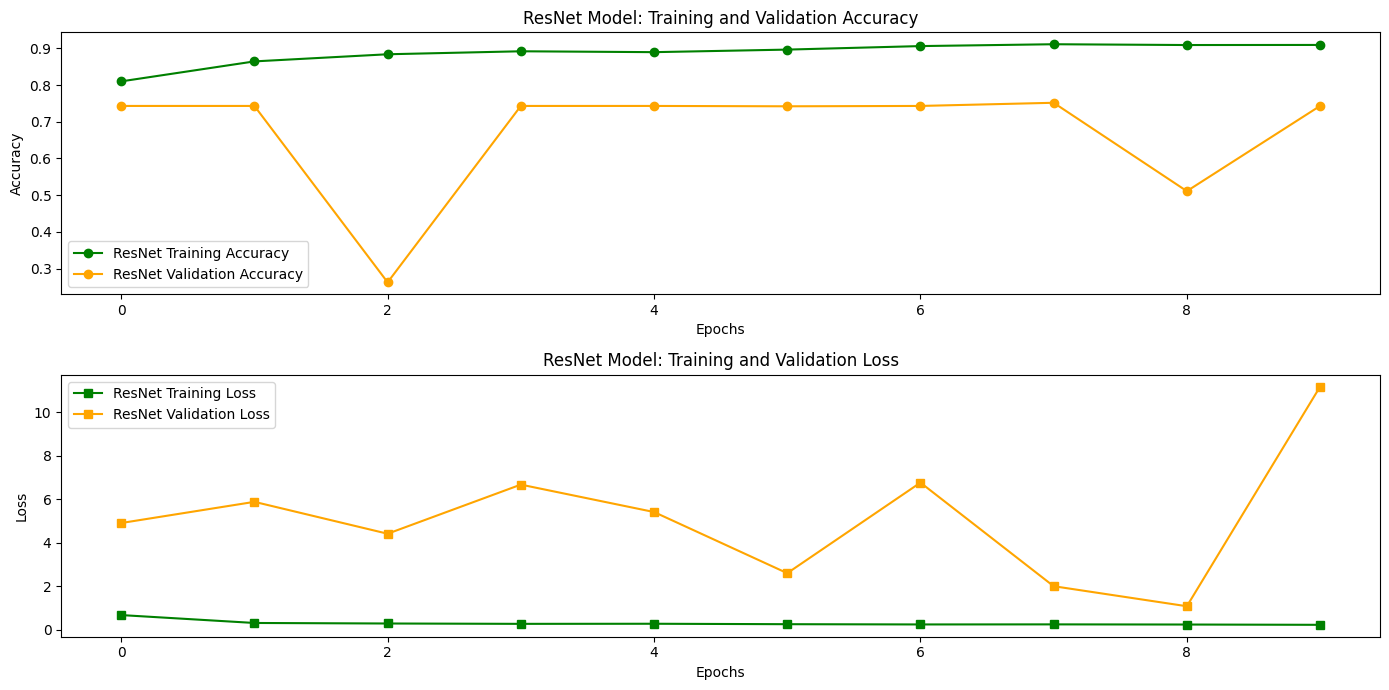

In [38]:
# Plotting for ResNet Model
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(resnet_history.history['accuracy'], marker='o', label='ResNet Training Accuracy', color='green')
plt.plot(resnet_history.history['val_accuracy'], marker='o', label='ResNet Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('ResNet Model: Training and Validation Accuracy')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(resnet_history.history['loss'], marker='s', label='ResNet Training Loss', color='green')
plt.plot(resnet_history.history['val_loss'], marker='s', label='ResNet Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('ResNet Model: Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


# EfficientNet

In [39]:
efficientnet_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [40]:
efficientnet_model.compile(optimizer=Adam(learning_rate=0.001),
                           loss='binary_crossentropy',
                           metrics=['accuracy'])

In [41]:
print("Training EfficientNet-inspired model...")
efficientnet_history = efficientnet_model.fit(
    train_chest_xray,
    validation_data=val_chest_xray,
    epochs=10
)

Training EfficientNet-inspired model...
Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 79s 538ms/step - accuracy: 0.7972 - loss: 0.8116 - val_accuracy: 0.7430 - val_loss: 10.6136
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 71s 518ms/step - accuracy: 0.8754 - loss: 0.2813 - val_accuracy: 0.7430 - val_loss: 8.9291
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 71s 520ms/step - accuracy: 0.8875 - loss: 0.2673 - val_accuracy: 0.7430 - val_loss: 5.1061
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 72s 525ms/step - accuracy: 0.9003 - loss: 0.2431 - val_accuracy: 0.4545 - val_loss: 1.3459
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 72s 526ms/step - accuracy: 0.9082 - loss: 0.2546 - val_accuracy: 0.9147 - val_loss: 0.1859
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 72s 526ms/step - accuracy: 0.9185 - loss: 0.2181 - val_accuracy: 0.7498 - val_loss: 2.4978
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 72s 525ms/step - accuracy: 0.9169 - loss: 0.2303 - val_accuracy: 0.7210 - val_loss: 0.5413
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 71

In [42]:
efficientnet_test_loss, efficientnet_test_accuracy = efficientnet_model.evaluate(test_chest_xray)
print(f"EfficientNet-inspired Model Test Accuracy: {efficientnet_test_accuracy:.2f}")
print(f"EfficientNet-inspired Model Test Loss: {efficientnet_test_loss:.2f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 410ms/step - accuracy: 0.6151 - loss: 3.7934
EfficientNet-inspired Model Test Accuracy: 0.63
EfficientNet-inspired Model Test Loss: 3.86


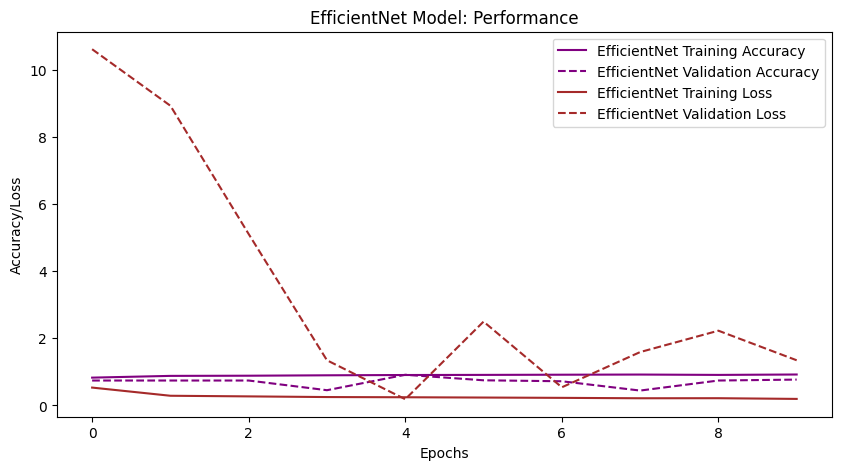

In [43]:
# Plotting for EfficientNet Model
plt.figure(figsize=(10, 5))
plt.plot(efficientnet_history.history['accuracy'], label='EfficientNet Training Accuracy', color='purple')
plt.plot(efficientnet_history.history['val_accuracy'], label='EfficientNet Validation Accuracy', color='purple', linestyle='--')
plt.plot(efficientnet_history.history['loss'], label='EfficientNet Training Loss', color='brown')
plt.plot(efficientnet_history.history['val_loss'], label='EfficientNet Validation Loss', color='brown', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.title('EfficientNet Model: Performance')
plt.legend()
plt.show()


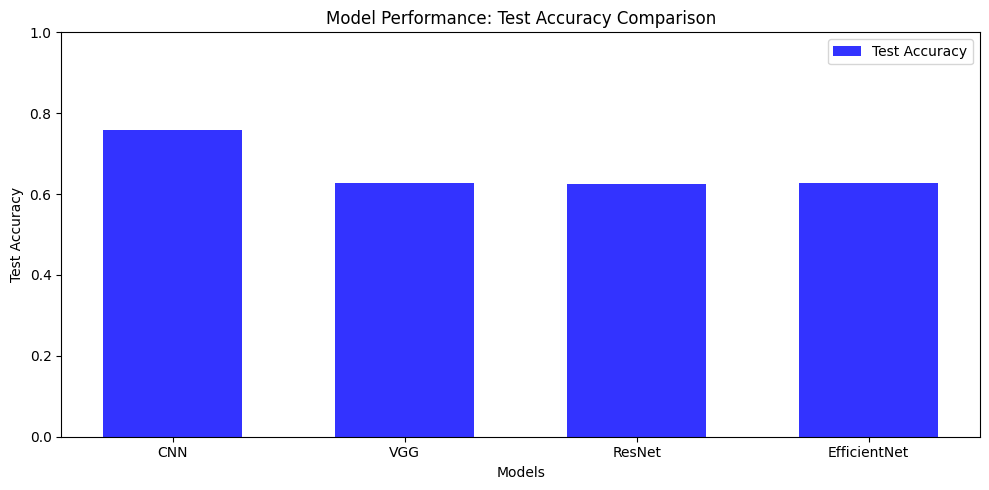

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Test results from the models (example values, replace with actual results)
test_results = {
    "CNN": test_accuracy,
    "VGG": vgg_test_accuracy,
    "ResNet": resnet_test_accuracy,
    "EfficientNet": efficientnet_test_accuracy
}

# Extract model names and accuracies
model_names = list(test_results.keys())
accuracies = list(test_results.values())

# Bar width and positions
x = np.arange(len(model_names))
bar_width = 0.6

# Create the bar graph
plt.figure(figsize=(10, 5))

# Plot accuracies
plt.bar(x, accuracies, bar_width, color='blue', alpha=0.8, label='Test Accuracy')

# Add labels, title, and legend
plt.xlabel('Models')
plt.ylabel('Test Accuracy')
plt.title('Model Performance: Test Accuracy Comparison')
plt.xticks(x, model_names)  # Add model names as x-axis labels
plt.ylim(0, 1)  # Accuracy range (0 to 1)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [66]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths for datasets
base_dir = '/content/drive/MyDrive/Disease Detection'
chest_xray_dir = f'{base_dir}/chest_xray'
melanoma_dir = '/content/drive/MyDrive/Disease Detection/melanoma_cancer_dataset-2'

# Define labels
label_mapping = {
    'NORMAL': 0,        # Chest X-ray: Normal
    'PNEUMONIA': 1,     # Chest X-ray: Pneumonia
    'benign': 2,        # Melanoma: Benign
    'malignant': 3      # Melanoma: Malignant
}

In [69]:
reorganized_dir = os.path.join(base_dir, 'Reorganized_Disease_Detection')
train_dir = os.path.join(reorganized_dir, 'train')
test_dir = os.path.join(reorganized_dir, 'test')

In [68]:
classes = ['Normal', 'Pneumonia', 'Benign', 'Malignant']

In [70]:
def create_directories(base_path, class_names):
    for subset in ['train', 'test']:
        subset_path = os.path.join(base_path, subset)
        os.makedirs(subset_path, exist_ok=True)
        for class_name in class_names:
            os.makedirs(os.path.join(subset_path, class_name), exist_ok=True)

create_directories(reorganized_dir, classes)

In [71]:
def move_files(src_dir, dest_dir, mapping):
    for class_name, folder_name in mapping.items():
        # Training data
        src_train = os.path.join(src_dir, 'train', folder_name)
        dest_train = os.path.join(dest_dir, 'train', class_name)
        if os.path.exists(src_train):
            for file in os.listdir(src_train):
                shutil.move(os.path.join(src_train, file), dest_train)

        # Test data
        src_test = os.path.join(src_dir, 'test', folder_name)
        dest_test = os.path.join(dest_dir, 'test', class_name)
        if os.path.exists(src_test):
            for file in os.listdir(src_test):
                shutil.move(os.path.join(src_test, file), dest_test)

In [72]:
mapping_chest_xray = {'Normal': 'NORMAL', 'Pneumonia': 'PNEUMONIA'}
mapping_melanoma = {'Benign': 'benign', 'Malignant': 'malignant'}

In [73]:
import shutil
move_files(chest_xray_dir, reorganized_dir, mapping_chest_xray)
move_files(melanoma_dir, reorganized_dir, mapping_melanoma)

In [75]:
for root, dirs, files in os.walk(melanoma_dir):
    level = root.replace(melanoma_dir, '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 4 * (level + 1)
    for f in files[:3]:
        print(f"{subindent}{f}")
    if len(files) > 3:
        print(f"{subindent}...and {len(files) - 3} more files")

melanoma_cancer_dataset-2/
    .DS_Store
    test/
        malignant/
        benign/
    train/
        malignant/
        benign/


In [78]:
base_dir = '/content/drive/MyDrive/Disease Detection/Reorganized_Disease_Detection'

In [90]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.mixed_precision import set_global_policy

#mixed precision for faster computations
set_global_policy('mixed_float16')

In [91]:
# Data augmentation and preprocessing
data_gen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Image size and batch size
img_size = (64, 64)
batch_size = 128

In [99]:
from sklearn.model_selection import train_test_split
import os
import shutil

# Base directory
train_dir = os.path.join(base_dir, 'train')
reduced_train_dir = os.path.join(base_dir, 'reduced_train')

# Create reduced_train directory
if not os.path.exists(reduced_train_dir):
    os.makedirs(reduced_train_dir)
    for class_name in os.listdir(train_dir):
        class_path = os.path.join(train_dir, class_name)
        if os.path.isdir(class_path):
            reduced_class_path = os.path.join(reduced_train_dir, class_name)
            os.makedirs(reduced_class_path)

            # List all files in the class folder
            all_files = os.listdir(class_path)
            train_files, _ = train_test_split(all_files, test_size=0.5, random_state=42)

            # Copy only 50% of the files
            for file_name in train_files:
                src_path = os.path.join(class_path, file_name)
                dst_path = os.path.join(reduced_class_path, file_name)
                shutil.copy(src_path, dst_path)

print("Reduced training set created at:", reduced_train_dir)

Reduced training set created at: /content/drive/MyDrive/Disease Detection/Reorganized_Disease_Detection/reduced_train


In [101]:
# Load training and validation data from the reduced dataset
train_combined = data_gen.flow_from_directory(
    reduced_train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_combined = data_gen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 7409 images belonging to 4 classes.
Found 2964 images belonging to 4 classes.


In [102]:
# Load test data
test_combined = data_gen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1624 images belonging to 4 classes.


In [103]:
# Define an optimized CNN model
def create_cnn_model():
    model = Sequential([
        Input(shape=(img_size[0], img_size[1], 3)),
        Conv2D(32, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        Dropout(0.4),
        Dense(4, activation='softmax')  # Multi-class classification
    ])

    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Create the model
model = create_cnn_model()

In [104]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

In [105]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

In [106]:
history = model.fit(
    train_combined,
    validation_data=val_combined,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


58/58 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.5252 - loss: 4.4398 - val_accuracy: 0.3374 - val_loss: 5.1918 - learning_rate: 5.0000e-04
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.8385 - loss: 2.4448 - val_accuracy: 0.3374 - val_loss: 5.4956 - learning_rate: 5.0000e-04
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.8528 - loss: 1.9044 - val_accuracy: 0.3374 - val_loss: 5.0941 - learning_rate: 5.0000e-04
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.8612 - loss: 1.4867 - val_accuracy: 0.3492 - val_loss: 3.0417 - learning_rate: 5.0000e-04
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.8705 - loss: 1.1838 - val_accuracy: 0.4474 - val_loss: 2.1760 - learning_rate: 5.0000e-04
Epoch 6/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.8869 - loss: 0.9418 - val_accuracy: 0.6609 - val_loss: 1.4125 - learning_rate: 5.0000e-04
Epoch 7/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.8824 - loss: 0.7875 - v

In [109]:
# Load test data from the 'test' directory
test_combined = data_gen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_combined)
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Loss: {test_loss:.2f}")

Found 1624 images belonging to 4 classes.
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8818 - loss: 0.3783
Test Accuracy: 0.87
Test Loss: 0.39


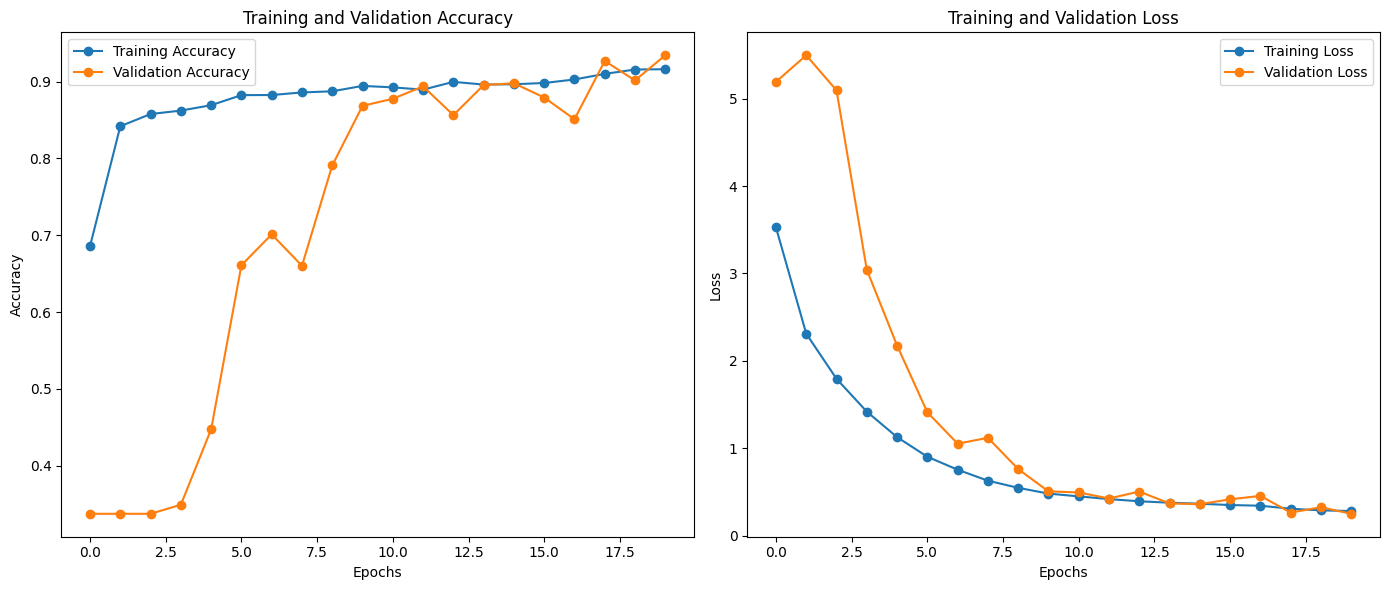

In [110]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Plot training and validation accuracy
plt.figure(figsize=(14, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 852ms/step


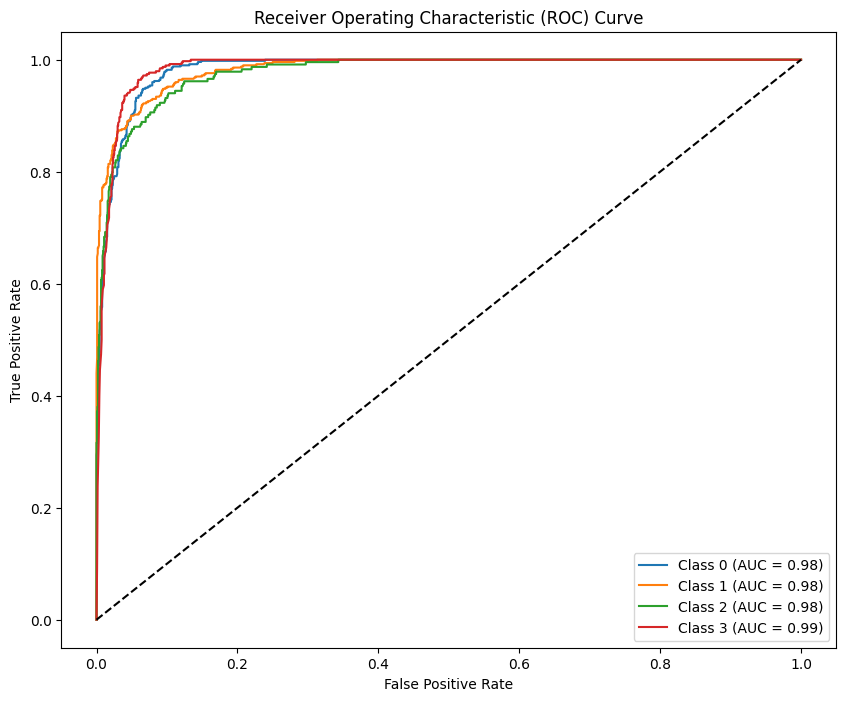

In [111]:
# Compute ROC and AUC for each class
y_test = []
y_pred = []

# Collect true labels and predictions for the test set
for images, labels in test_combined:
    y_test.extend(labels)
    preds = model.predict(images)
    y_pred.extend(preds)
    if len(y_test) >= test_combined.samples:  # Stop when all test samples are processed
        break

# Convert to numpy arrays
y_test = np.array(y_test)
y_pred = np.array(y_pred)

# Binarize true labels for multi-class ROC
y_test_bin = label_binarize(y_test.argmax(axis=1), classes=range(y_test.shape[1]))
n_classes = y_test.shape[1]

# Plot ROC for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


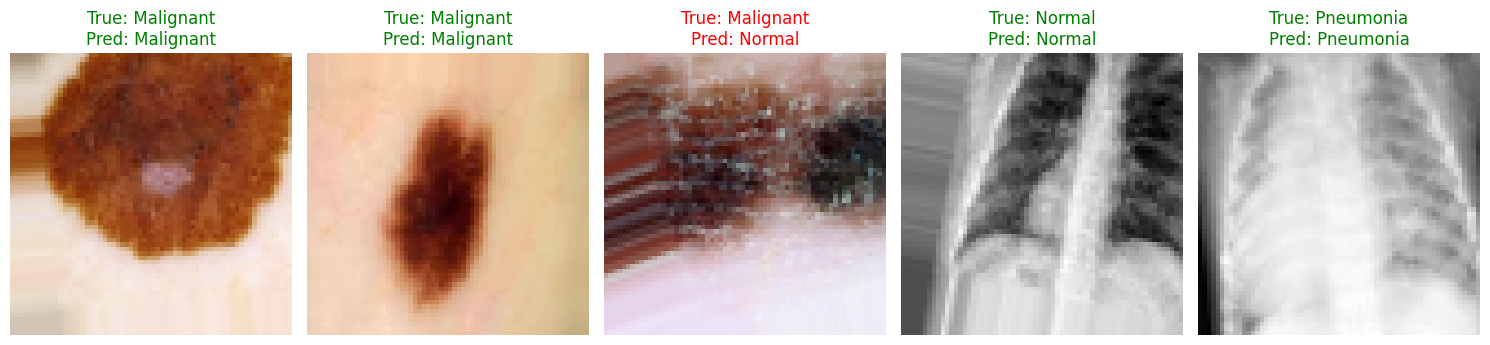

In [113]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import array_to_img

# Map class indices to labels
class_labels = {v: k for k, v in test_combined.class_indices.items()}

# Function to display random predictions
def show_predictions(model, data_generator, num_samples=5):
    plt.figure(figsize=(15, 10))
    images, labels = next(data_generator)  # Get a batch of images and labels
    predictions = model.predict(images)

    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        img = array_to_img(images[i])  # Convert image array to a displayable format
        true_label = class_labels[np.argmax(labels[i])]
        predicted_label = class_labels[np.argmax(predictions[i])]
        plt.imshow(img)
        plt.title(f'True: {true_label}\nPred: {predicted_label}', color='green' if true_label == predicted_label else 'red')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Show predictions on random samples
show_predictions(model, test_combined)